<a href="https://colab.research.google.com/github/zihangdai/xlnet/blob/master/notebooks/colab_imdb_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XLNet IMDB movie review classification project

This notebook is for classifying the [imdb sentiment dataset](https://ai.stanford.edu/~amaas/data/sentiment/).  It will be easy to edit this notebook in order to run all of the classification tasks referenced in the [XLNet paper](https://arxiv.org/abs/1906.08237). Whilst you cannot expect to obtain the state-of-the-art results in the paper on a GPU, this model will still score very highly. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup
Install dependencies

In [ ]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 35.4 MB/s 


Download the pretrained XLNet model and unzip

In [ ]:
# only needs to be done once
! wget https://storage.googleapis.com/xlnet/released_models/cased_L-24_H-1024_A-16.zip
! unzip cased_L-24_H-1024_A-16.zip 

--2022-11-20 10:25:33--  https://storage.googleapis.com/xlnet/released_models/cased_L-24_H-1024_A-16.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1338042341 (1.2G) [application/zip]
Saving to: ‘cased_L-24_H-1024_A-16.zip’

cased_L-24_H-1024_A 100%[===================>]   1.25G  13.3MB/s    in 96s     

2022-11-20 10:27:11 (13.3 MB/s) - ‘cased_L-24_H-1024_A-16.zip’ saved [1338042341/1338042341]

Archive:  cased_L-24_H-1024_A-16.zip
   creating: xlnet_cased_L-24_H-1024_A-16/
  inflating: xlnet_cased_L-24_H-1024_A-16/xlnet_model.ckpt.index  
  inflating: xlnet_cased_L-24_H-1024_A-16/xlnet_model.ckpt.data-00000-of-00001  
  inflating: xlnet_cased_L-24_H-1024_A-16/spiece.model  
  inflating: xlnet_cased_L-24_H-1024_A-16/xlnet_model.ckpt.meta  
  inflating: xlnet_cased_L-24_

Download extract the imdb dataset - surpessing output

In [ ]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar zxf aclImdb_v1.tar.gz

--2022-11-20 10:27:24--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  15.9MB/s    in 8.4s    

2022-11-20 10:27:33 (9.55 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Git clone XLNet repo for access to run_classifier and the rest of the xlnet module

In [ ]:
! git clone https://github.com/zihangdai/xlnet.git

Cloning into 'xlnet'...
remote: Enumerating objects: 122, done.
remote: Total 122 (delta 0), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (122/122), 2.92 MiB | 38.34 MiB/s, done.
Resolving deltas: 100% (59/59), done.


### 파이썬, tf, numpy, cuda, cudnn 버전 변경


In [ ]:
! python3.7 -m pip install tensorflow-gpu==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.5 MB 7.6 kB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
     |████████████████████████████████| 503 kB 58.9 MB/s 
     |████████████████████████████████| 3.8 MB 59.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=daf6637f793bb6a61d3069d4ba464d0b4ce680ca8570fc550dd9f4ef08eca779
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting u

In [ ]:
! pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.8 MB 26.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.9.2 requires tensorboard<2.10,>=2.9, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.9.2 requires tensorflow-estimator<2.10.0,>=2.9.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.
tensorflow-probability 0.17.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
j

In [ ]:
#Uninstall the current CUDA version
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'


In [ ]:
#Download CUDA 10.0
!wget  --no-clobber https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
#install CUDA kit dpkg
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda-10-0

--2022-11-20 10:29:12--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2942 (2.9K) [application/x-deb]
Saving to: ‘cuda-repo-ubuntu1804_10.0.130-1_amd64.deb’

cuda-repo-ubuntu180 100%[===================>]   2.87K  --.-KB/s    in 0s      

2022-11-20 10:29:12 (160 MB/s) - ‘cuda-repo-ubuntu1804_10.0.130-1_amd64.deb’ saved [2942/2942]

Selecting previously unselected package cuda-repo-ubuntu1804.
(Reading database ... 115763 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1804_10.0.130-1_amd64.deb ...
Unpacking cuda-repo-ubuntu1804 (10.0.130-1) ...
Setting up cuda-repo-ubuntu1804 (10.0.130-1) ...
Executing: /tmp/apt-key-gpghome.cLfD5qNm

In [ ]:
!dpkg -i "/content/drive/MyDrive/강의/2022-2학기/NLP/libcudnn7_7.5.0.56-1+cuda10.0_amd64.deb"
# Check if package has been installed
!ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.7*

In [ ]:
!nvcc --version

In [ ]:
!cat /usr/include/x86_64-linux-gnu/cudnn_v*.h | grep CUDNN_MAJOR -A 2

In [ ]:
! nvidia-smi

## Define Variables
Define all the dirs: data, xlnet scripts & pretrained model. 
If you would like to save models then you can authenticate a GCP account and use that for the OUTPUT_DIR & CHECKPOINT_DIR - you will need a large amount storage to fix these models. 

Alternatively it is easy to integrate a google drive account, checkout this guide for [I/O in colab](https://colab.research.google.com/notebooks/io.ipynb) but rememeber these will take up a large amount of storage. 


In [ ]:
SCRIPTS_DIR = 'xlnet' #@param {type:"string"}
DATA_DIR = 'aclImdb' #@param {type:"string"}
OUTPUT_DIR = 'proc_data/imdb' #@param {type:"string"}
PRETRAINED_MODEL_DIR = 'xlnet_cased_L-24_H-1024_A-16' #@param {type:"string"}
CHECKPOINT_DIR = 'exp/imdb' #@param {type:"string"}

## Run Model
This will set off the fine tuning of XLNet. There are a few things to note here:


1.   This script will train and evaluate the model
2.   This will store the results locally on colab and will be lost when you are disconnected from the runtime
3.   This uses the large version of the model (base not released presently)
4.   We are using a max seq length of 128 with a batch size of 8 please refer to the [README](https://github.com/zihangdai/xlnet#memory-issue-during-finetuning) for why this is.
5. This will take approx 4hrs to run on GPU.



# 학습과정 설명

Xlnet은 permutation learning 방식으로 학습되는 language model이다. permutation learning은 autoregression 방식과 autoencoder 방식의 장점을 합친 language model 학습 방식이다. <br><br>
Autoregression 방식은 이전 step까지의 단어가 주어졌을 때 현재 step의 단어의 likelihood가 최대화되도록 학습하는 방법이다. 이 방법은 현재 step의 단어를 예측할 때 미래 step의 단어들과의 상관관계를 모델이 학습할 수 없다는 단점이 있다. AR의 수식적 표현은 아래와 같다.<br>
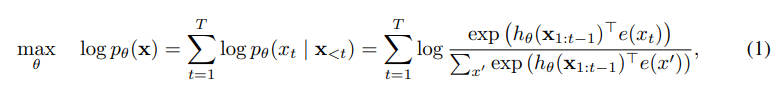
 <br><br>
Autoencoder 방식은 입력 문장의 일부를 마스킹하여 모델에 입력하고 마스킹 되기 전의 입력 문장을 label로 사용하여 원래의 입력 문장이 출력되도록 모델을 학습시키는 방법이다. 이 방법은 마스킹된 단어를 모델이 예측할 때 이후 step의 단어들과의 상관관계 또한 사용할 수 있다는 장점이 있지만 마스킹된 단어들은 서로 독립이라고 가정되기 때문에 마스킹된 단어 사이의 상관관계를 학습할 수 없다는 단점이 있다. AE의 수식적 표현은 아래와 같다. <br>
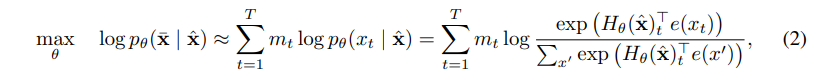
 <br><br>
Permutation learning은 위 두가지 방법의 단점을 보완한 학습 방법이다. Permutation learning에서는 autoregression 방식으로 이전 step의 단어들을 사용하여 현재 step의 단어의 우도가 최대화되도록 학습하는데, 이 때 단어의 step이 무작위로 섞인 채로 학습된다. (아래 식 참고)<br>
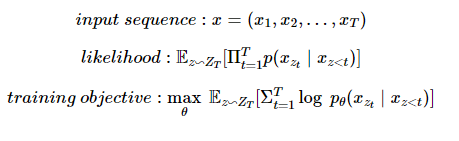

Permuation learning은 autoencoder처럼 마스킹을 하지 않으니 모든 단어 사이의 상관관계를 학습할 수 있고, autoregression 방식으로 likelihood를 계산할 때 단어의 순서를 무작위로 섞기 때문에 기존의 autoregression과 달리 미래 step의 단어와의 상관관계도 학습할 수 있다. <br>
Xlnet은 Two-Stream Self-Attention for Target-Aware Representations라는 방식으로 학습되는데 아래 그림과 같다. <br>
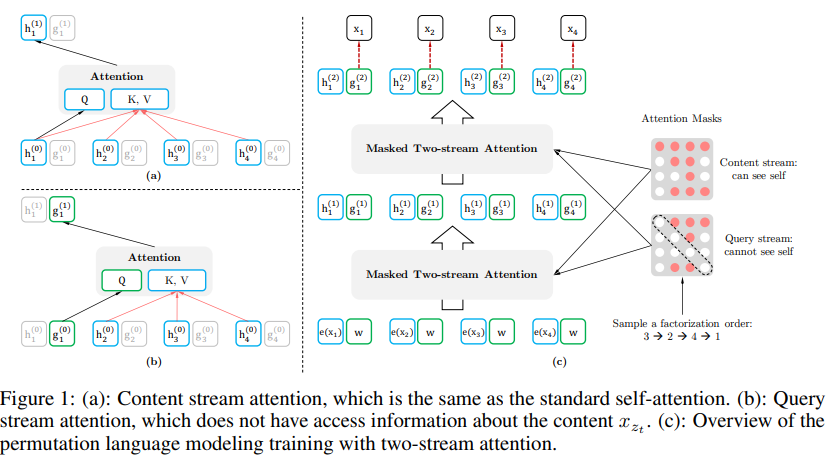 <br>
토큰의 순서가 permutation 된 채로 학습될 수 있도록 기존의 attention mask matrix를 permutation한 형태의 attention mask를 사용한다.

## Permutation Learning 코드
Permuatation learning은 모델에 입력되는 토큰의 순서를 무작위로 변경해서 이루어지는데, 입력 데이터의 순서를 섞는 과정은은 data_utils.py의 _create_data() 함수에 아래와 같이 구현되어있다. <br>
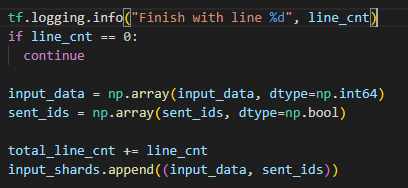
<br>
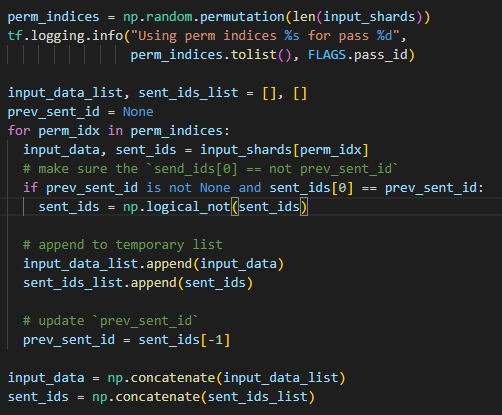
<br><br>

train.py의 main() 함수에서는 data_utils.py의 get_input_fn() 함수를 사용해 모델의 forward에 사용될 permutation된 입력 문장을 생성한다. 입력과 마스크를 생성하는 코드는 아래와 같다.


In [ ]:
def _local_perm(inputs, targets, is_masked, perm_size, seq_len):
  """
  Sample a permutation of the factorization order, and create an
  attention mask accordingly.

  Args:
    inputs: int64 Tensor in shape [seq_len], input ids.
    targets: int64 Tensor in shape [seq_len], target ids.
    is_masked: bool Tensor in shape [seq_len]. True means being selected
      for partial prediction.
    perm_size: the length of longest permutation. Could be set to be reuse_len.
      Should not be larger than reuse_len or there will be data leaks.
    seq_len: int, sequence length.
  """

  # Generate permutation indices
  index = tf.range(seq_len, dtype=tf.int64)
  index = tf.transpose(tf.reshape(index, [-1, perm_size]))
  index = tf.random_shuffle(index)
  index = tf.reshape(tf.transpose(index), [-1])

  # `perm_mask` and `target_mask`
  # non-functional tokens
  non_func_tokens = tf.logical_not(tf.logical_or(
      tf.equal(inputs, SEP_ID),
      tf.equal(inputs, CLS_ID)))

  non_mask_tokens = tf.logical_and(tf.logical_not(is_masked), non_func_tokens)
  masked_or_func_tokens = tf.logical_not(non_mask_tokens)

  # Set the permutation indices of non-masked (& non-funcional) tokens to the
  # smallest index (-1):
  # (1) they can be seen by all other positions
  # (2) they cannot see masked positions, so there won"t be information leak
  smallest_index = -tf.ones([seq_len], dtype=tf.int64)
  rev_index = tf.where(non_mask_tokens, smallest_index, index)

  # Create `target_mask`: non-funcional and maksed tokens
  # 1: use mask as input and have loss
  # 0: use token (or [SEP], [CLS]) as input and do not have loss
  target_tokens = tf.logical_and(masked_or_func_tokens, non_func_tokens)
  target_mask = tf.cast(target_tokens, tf.float32)

  # Create `perm_mask`
  # `target_tokens` cannot see themselves
  self_rev_index = tf.where(target_tokens, rev_index, rev_index + 1)

  # 1: cannot attend if i <= j and j is not non-masked (masked_or_func_tokens)
  # 0: can attend if i > j or j is non-masked
  perm_mask = tf.logical_and(
      self_rev_index[:, None] <= rev_index[None, :],
      masked_or_func_tokens)
  perm_mask = tf.cast(perm_mask, tf.float32)

  # new target: [next token] for LM and [curr token] (self) for PLM
  new_targets = tf.concat([inputs[0: 1], targets[: -1]],
                          axis=0)

  # construct inputs_k
  inputs_k = inputs

  # construct inputs_q
  inputs_q = target_mask

  return perm_mask, new_targets, target_mask, inputs_k, inputs_q

그리고 local_perm() 함수에서 얻은 입력과 마스크를 사용하여 실제 모델에 들어갈 input과 target을 생성한다. <br>

In [ ]:
if num_predict is not None:
      indices = tf.range(seq_len, dtype=tf.int64)
      bool_target_mask = tf.cast(target_mask, tf.bool)
      indices = tf.boolean_mask(indices, bool_target_mask)

      ##### extra padding due to CLS/SEP introduced after prepro
      actual_num_predict = tf.shape(indices)[0]
      pad_len = num_predict - actual_num_predict

      ##### target_mapping
      target_mapping = tf.one_hot(indices, seq_len, dtype=tf.float32)
      paddings = tf.zeros([pad_len, seq_len], dtype=target_mapping.dtype)
      target_mapping = tf.concat([target_mapping, paddings], axis=0)
      example["target_mapping"] = tf.reshape(target_mapping,
                                             [num_predict, seq_len])

      ##### target
      target = tf.boolean_mask(target, bool_target_mask)
      paddings = tf.zeros([pad_len], dtype=target.dtype)
      target = tf.concat([target, paddings], axis=0)
      example["target"] = tf.reshape(target, [num_predict])

      ##### target mask
      target_mask = tf.concat(
          [tf.ones([actual_num_predict], dtype=tf.float32),
           tf.zeros([pad_len], dtype=tf.float32)],
          axis=0)
      example["target_mask"] = tf.reshape(target_mask, [num_predict])

그리고 function_builder.py의 get_classification_loss() 함수에서 실제로 xlnet 모델에 입력 문장을 입력한다.

In [ ]:
def get_classification_loss(
    FLAGS, features, n_class, is_training):
  """Loss for downstream classification tasks."""

  bsz_per_core = tf.shape(features["input_ids"])[0]

  inp = tf.transpose(features["input_ids"], [1, 0])
  seg_id = tf.transpose(features["segment_ids"], [1, 0])
  inp_mask = tf.transpose(features["input_mask"], [1, 0])
  label = tf.reshape(features["label_ids"], [bsz_per_core])

  xlnet_config = xlnet.XLNetConfig(json_path=FLAGS.model_config_path)
  run_config = xlnet.create_run_config(is_training, True, FLAGS)

  xlnet_model = xlnet.XLNetModel(
      xlnet_config=xlnet_config,
      run_config=run_config,
      input_ids=inp,
      seg_ids=seg_id,
      input_mask=inp_mask)

  summary = xlnet_model.get_pooled_out(FLAGS.summary_type, FLAGS.use_summ_proj)

  with tf.variable_scope("model", reuse=tf.AUTO_REUSE):

    if FLAGS.cls_scope is not None and FLAGS.cls_scope:
      cls_scope = "classification_{}".format(FLAGS.cls_scope)
    else:
      cls_scope = "classification_{}".format(FLAGS.task_name.lower())

    per_example_loss, logits = modeling.classification_loss(
        hidden=summary,
        labels=label,
        n_class=n_class,
        initializer=xlnet_model.get_initializer(),
        scope=cls_scope,
        return_logits=True)

    total_loss = tf.reduce_mean(per_example_loss)

    return total_loss, per_example_loss, logits

모델에서 실제 포워딩이 일어나는 코드는 아래와 같다. 먼저 마스크를 생성하고 워드임베딩, 세그먼트 임베딩, 포지셔널 인코딩을 수행한다. 

In [ ]:
# data mask: input mask & perm mask
    if input_mask is not None and perm_mask is not None:
      data_mask = input_mask[None] + perm_mask
    elif input_mask is not None and perm_mask is None:
      data_mask = input_mask[None]
    elif input_mask is None and perm_mask is not None:
      data_mask = perm_mask
    else:
      data_mask = None

    if data_mask is not None:
      # all mems can be attended to
      mems_mask = tf.zeros([tf.shape(data_mask)[0], mlen, bsz],
                           dtype=tf_float)
      data_mask = tf.concat([mems_mask, data_mask], 1)
      if attn_mask is None:
        attn_mask = data_mask[:, :, :, None]
      else:
        attn_mask += data_mask[:, :, :, None]

    if attn_mask is not None:
      attn_mask = tf.cast(attn_mask > 0, dtype=tf_float)

    if attn_mask is not None:
      non_tgt_mask = -tf.eye(qlen, dtype=tf_float)
      non_tgt_mask = tf.concat([tf.zeros([qlen, mlen], dtype=tf_float),
                                non_tgt_mask], axis=-1)
      non_tgt_mask = tf.cast((attn_mask + non_tgt_mask[:, :, None, None]) > 0,
                             dtype=tf_float)
    else:
      non_tgt_mask = None

    ##### Word embedding
    word_emb_k, lookup_table = embedding_lookup(
        x=inp_k,
        n_token=n_token,
        d_embed=d_model,
        initializer=initializer,
        use_tpu=use_tpu,
        dtype=tf_float,
        scope='word_embedding')

    if inp_q is not None:
      with tf.variable_scope('mask_emb'):
        mask_emb = tf.get_variable('mask_emb', [1, 1, d_model], dtype=tf_float)
        if target_mapping is not None:
          word_emb_q = tf.tile(mask_emb, [tf.shape(target_mapping)[0], bsz, 1])
        else:
          inp_q_ext = inp_q[:, :, None]
          word_emb_q = inp_q_ext * mask_emb + (1 - inp_q_ext) * word_emb_k
    output_h = tf.layers.dropout(word_emb_k, dropout, training=is_training)
    if inp_q is not None:
      output_g = tf.layers.dropout(word_emb_q, dropout, training=is_training)

    ##### Segment embedding
    if seg_id is not None:
      if untie_r:
        r_s_bias = tf.get_variable('r_s_bias', [n_layer, n_head, d_head],
                                   dtype=tf_float, initializer=initializer)
      else:
        # default case (tie)
        r_s_bias = tf.get_variable('r_s_bias', [n_head, d_head],
                                   dtype=tf_float, initializer=initializer)

      seg_embed = tf.get_variable('seg_embed', [n_layer, 2, n_head, d_head],
                                  dtype=tf_float, initializer=initializer)

      # Convert `seg_id` to one-hot `seg_mat`
      mem_pad = tf.zeros([mlen, bsz], dtype=tf.int32)
      cat_ids = tf.concat([mem_pad, seg_id], 0)

      # `1` indicates not in the same segment [qlen x klen x bsz]
      seg_mat = tf.cast(
          tf.logical_not(tf.equal(seg_id[:, None], cat_ids[None, :])),
          tf.int32)
      seg_mat = tf.one_hot(seg_mat, 2, dtype=tf_float)
    else:
      seg_mat = None

    ##### Positional encoding
    pos_emb = relative_positional_encoding(
        qlen, klen, d_model, clamp_len, attn_type, bi_data,
        bsz=bsz, dtype=tf_float)
    pos_emb = tf.layers.dropout(pos_emb, dropout, training=is_training)

아래 코드를 사용해 초기 representation을 생성한다.

In [ ]:
    output_h = tf.layers.dropout(word_emb_k, dropout, training=is_training)
    if inp_q is not None:
      output_g = tf.layers.dropout(word_emb_q, dropout, training=is_training)

Two stream relative attention에 해당하는 코드는 아래와 같다. modelling.py에 함수로 정의되어 있다.

In [ ]:
def two_stream_rel_attn(h, g, r, mems, r_w_bias, r_r_bias, seg_mat, r_s_bias,
                        seg_embed, attn_mask_h, attn_mask_g, target_mapping,
                        d_model, n_head, d_head, dropout, dropatt, is_training,
                        kernel_initializer, scope='rel_attn'):
  """Two-stream attention with relative positional encoding."""

  scale = 1 / (d_head ** 0.5)
  with tf.variable_scope(scope, reuse=False):

    # content based attention score
    if mems is not None and mems.shape.ndims > 1:
      cat = tf.concat([mems, h], 0)
    else:
      cat = h

    # content-based key head
    k_head_h = head_projection(
        cat, d_model, n_head, d_head, kernel_initializer, 'k')

    # content-based value head
    v_head_h = head_projection(
        cat, d_model, n_head, d_head, kernel_initializer, 'v')

    # position-based key head
    k_head_r = head_projection(
        r, d_model, n_head, d_head, kernel_initializer, 'r')

    ##### h-stream
    # content-stream query head
    q_head_h = head_projection(
        h, d_model, n_head, d_head, kernel_initializer, 'q')

    # core attention ops
    attn_vec_h = rel_attn_core(
        q_head_h, k_head_h, v_head_h, k_head_r, seg_embed, seg_mat, r_w_bias,
        r_r_bias, r_s_bias, attn_mask_h, dropatt, is_training, scale)

    # post processing
    output_h = post_attention(h, attn_vec_h, d_model, n_head, d_head, dropout,
                              is_training, kernel_initializer)

  with tf.variable_scope(scope, reuse=True):
    ##### g-stream
    # query-stream query head
    q_head_g = head_projection(
        g, d_model, n_head, d_head, kernel_initializer, 'q')

    # core attention ops
    if target_mapping is not None:
      q_head_g = tf.einsum('mbnd,mlb->lbnd', q_head_g, target_mapping)
      attn_vec_g = rel_attn_core(
          q_head_g, k_head_h, v_head_h, k_head_r, seg_embed, seg_mat, r_w_bias,
          r_r_bias, r_s_bias, attn_mask_g, dropatt, is_training, scale)
      attn_vec_g = tf.einsum('lbnd,mlb->mbnd', attn_vec_g, target_mapping)
    else:
      attn_vec_g = rel_attn_core(
          q_head_g, k_head_h, v_head_h, k_head_r, seg_embed, seg_mat, r_w_bias,
          r_r_bias, r_s_bias, attn_mask_g, dropatt, is_training, scale)

    # post processing
    output_g = post_attention(g, attn_vec_g, d_model, n_head, d_head, dropout,
                              is_training, kernel_initializer)

    return output_h, output_g

앞에서 구현한 것들을 사용해서 실제로  query stream attention을 수행하는 코드이다. 

In [ ]:
  with tf.variable_scope(scope, reuse=True):
    ##### g-stream
    # query-stream query head
    q_head_g = head_projection(
        g, d_model, n_head, d_head, kernel_initializer, 'q')

    # core attention ops
    if target_mapping is not None:
      q_head_g = tf.einsum('mbnd,mlb->lbnd', q_head_g, target_mapping)
      attn_vec_g = rel_attn_core(
          q_head_g, k_head_h, v_head_h, k_head_r, seg_embed, seg_mat, r_w_bias,
          r_r_bias, r_s_bias, attn_mask_g, dropatt, is_training, scale)
      attn_vec_g = tf.einsum('lbnd,mlb->mbnd', attn_vec_g, target_mapping)
    else:
      attn_vec_g = rel_attn_core(
          q_head_g, k_head_h, v_head_h, k_head_r, seg_embed, seg_mat, r_w_bias,
          r_r_bias, r_s_bias, attn_mask_g, dropatt, is_training, scale)

    # post processing
    output_g = post_attention(g, attn_vec_g, d_model, n_head, d_head, dropout,
                              is_training, kernel_initializer)

    return output_h, output_g

다시 function_builder.py로 돌아오면 실제 loss를 계산하는 코드가 있다. total_loss가 최종 loss이다.

In [ ]:
  output = xlnet_model.get_sequence_output()
  new_mems = {mem_name: xlnet_model.get_new_memory()}
  lookup_table = xlnet_model.get_embedding_table()

  initializer = xlnet_model.get_initializer()

  with tf.variable_scope("model", reuse=tf.AUTO_REUSE):
    # LM loss
    lm_loss = modeling.lm_loss(
        hidden=output,
        target=tgt,
        n_token=xlnet_config.n_token,
        d_model=xlnet_config.d_model,
        initializer=initializer,
        lookup_table=lookup_table,
        tie_weight=True,
        bi_data=run_config.bi_data,
        use_tpu=run_config.use_tpu)

  #### Quantity to monitor
  monitor_dict = {}

  if FLAGS.use_bfloat16:
    tgt_mask = tf.cast(tgt_mask, tf.float32)
    lm_loss = tf.cast(lm_loss, tf.float32)

  total_loss = tf.reduce_sum(lm_loss * tgt_mask) / tf.reduce_sum(tgt_mask)
  monitor_dict["total_loss"] = total_loss

  return total_loss, new_mems, monitor_dict

loss는 lm_loss() 함수를 통해 계산되는데 lm_loss는 아래와 같이 sparse_softmax_cross_entropy_with_logits 함수를 사용해 구현되어있다.

In [ ]:
def lm_loss(hidden, target, n_token, d_model, initializer, lookup_table=None,
            tie_weight=False, bi_data=True, use_tpu=False):
  """doc."""

  with tf.variable_scope('lm_loss'):
    if tie_weight:
      assert lookup_table is not None, \
          'lookup_table cannot be None for tie_weight'
      softmax_w = lookup_table
    else:
      softmax_w = tf.get_variable('weight', [n_token, d_model],
                                  dtype=hidden.dtype, initializer=initializer)

    softmax_b = tf.get_variable('bias', [n_token], dtype=hidden.dtype,
                                initializer=tf.zeros_initializer())

    logits = tf.einsum('ibd,nd->ibn', hidden, softmax_w) + softmax_b

    if use_tpu:
      one_hot_target = tf.one_hot(target, n_token, dtype=logits.dtype)
      loss = -tf.reduce_sum(tf.nn.log_softmax(logits) * one_hot_target, -1)
    else:
      loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target,
                                                            logits=logits)

    return loss

# 모델 학습/검증

500 step의 warm up step, 4000번의 training step으로 모델을 학습시킨다. IMDB 데이터셋을 사용해 language model을 학습한다.

In [ ]:
train_command = "python xlnet/run_classifier.py \
  --do_train=True \
  --do_eval=True \
  --eval_all_ckpt=True \
  --task_name=imdb \
  --data_dir="+DATA_DIR+" \
  --output_dir="+OUTPUT_DIR+" \
  --model_dir="+CHECKPOINT_DIR+" \
  --uncased=False \
  --spiece_model_file="+PRETRAINED_MODEL_DIR+"/spiece.model \
  --model_config_path="+PRETRAINED_MODEL_DIR+"/xlnet_config.json \
  --init_checkpoint="+PRETRAINED_MODEL_DIR+"/xlnet_model.ckpt \
  --max_seq_length=128 \
  --train_batch_size=8 \
  --eval_batch_size=8 \
  --num_hosts=1 \
  --num_core_per_host=1 \
  --learning_rate=2e-5 \
  --train_steps=4000 \
  --warmup_steps=500 \
  --save_steps=500 \
  --iterations=500"

! {train_command}





W1114 12:36:19.354026 139760147232640 module_wrapper.py:139] From xlnet/run_classifier.py:637: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W1114 12:36:19.354227 139760147232640 module_wrapper.py:139] From xlnet/run_classifier.py:637: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W1114 12:36:19.354402 139760147232640 module_wrapper.py:139] From xlnet/run_classifier.py:661: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.


W1114 12:36:19.412359 139760147232640 module_wrapper.py:139] From /content/xlnet/model_utils.py:27: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


W1114 12:36:19.412630 139760147232640 module_wrapper.py:139] From /content/xlnet/model_utils.py:36: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Single device mode.
I1114 12:36:19.412736 139760

## Running & Results
These are the results that I got from running this experiment
### Params
*    --max_seq_length=128 \
*    --train_batch_size= 8 

### Times
*   Training: 1hr 11mins
*   Evaluation: 2.5hr

### Results
*  Most accurate model on final step
*  Accuracy: 0.92416, eval_loss: 0.31708


### Model

*   The trained model checkpoints can be found in 'exp/imdb'

